In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics
pd.set_option('display.max_columns',500)

In [2]:
df_2020 = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")
df_2023 = pd.read_csv("csv_data/merged/Spring2023Merged_goodRuns.csv")
df_2025 = pd.read_csv("csv_data/merged/Spring2025Merged_goodRuns.csv")

/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_57051/1971075393.py:1: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")
/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_57051/1971075393.py:2: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("csv_data/merged/Spring2023Merged_goodRuns.csv")
/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_57051/1971075393.py:3: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2025 = pd.read_csv("csv_data/merged/Spring2025Merged_goodRuns.csv")


In [3]:
# selects runs that have a single nudge of a normal size
def select_data(df_in):
    df_out = df_in[(df_in['RunHasNudge'])&(~df_in['RunHasAbnormalNudge'])&(df_in['TotalNudges_thisRun']==1)&(~df_in['RunHasBacklash'])]
    return df_out 

In [4]:
df_2020 = select_data(df_2020)
df_2023 = select_data(df_2023)
df_2025 = select_data(df_2025)

In [5]:
# copy viz code from other notebook (or make it a utility aviailble to all would be better)
nudge_run_list_2020 = df_2020['RunNumber'].unique()
nudge_run_list_2023 = df_2023['RunNumber'].unique()
nudge_run_list_2025 = df_2025['RunNumber'].unique()

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import statistics
pd.set_option('display.max_columns',500)

def plot_run(runNumber, df_in):

    print("plotting for run ",runNumber)
    # RunHasNudge only true for moment nudge occurs (need to fix still)
    df_run_nudges = df_in[((df_in['RunNumber']==runNumber)&(df_in['NudgeOccurred']))]
    df_run_nudges.reset_index(inplace=True)

    # min and max coherent edge energy to include
    minE = 8550
    maxE = 8650
    expectedE = 8600

    if (runNumber>80000) and (runNumber < 130000):
        minE = 8520
        maxE = 8720
        expectedE = 8620
    elif runNumber>130000:
        minE = 8800
        maxE = 9000
        expectedE = 8900

    nudge_list = df_run_nudges['NudgeNumber'].unique()

    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
    
    set_energy_drawn = False
    nudge_label_set = False
    first_good_nudge = False

    nudge_times = []
    pitchDiffs = []
    yawDiffs = []
    set_ens = []

    first_time = 0
    max_nudge_time = 0
    
    
    for seq in nudge_list:

        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        df_this_nudge.reset_index(inplace=True)
        nudge_time = df_this_nudge.loc[0,'TimeStamp']

        if first_time==0:
            first_time = nudge_time

        current_pitchDiff = df_this_nudge.loc[0,'NudgePitchSize']        
        current_yawDiff = df_this_nudge.loc[0,'NudgeYawSize']
        current_roll = df_this_nudge.loc[0,'GONI:ROLL']

        # no clue what is causing this, nudges should never be this big. Config change?
        if abs(current_pitchDiff)>1 or abs(current_yawDiff)>1:
            #print(df_this_nudge)
            continue

        pitchDiffs.append(current_pitchDiff)
        yawDiffs.append(current_yawDiff)
        nudge_times.append(nudge_time)
            
        if nudge_time>max_nudge_time:
            max_nudge_time = nudge_time

        nudgeSize = (current_pitchDiff**2+current_yawDiff**2)**0.5

        # nudge of 0.001 should give 1 MeV change (is what I have been told)
        if abs(current_roll-34.5)<1.0:
            # all roll 34.5 configs have a negative E_gam change with a postive change in yaw
            if current_yawDiff>0:
                nudgeSize = -nudgeSize
        elif abs(current_roll+10.5)<1:
            # roll -10.5 PARA has +delta(yaw)->-delta(E)
            # but for PERP, yaw is fixed and +delta(pitch)->-delta(E)
            if df_this_nudge.loc[0,'CBREM:PLANE']==2:
                # PERP
                if current_pitchDiff>0:
                    nudgeSize = -nudgeSize
            elif df_this_nudge.loc[0,'CBREM:PLANE']==1:
                if current_yawDiff>0:
                    nudgeSize = -nudgeSize
        expectedEnChange = 3.0*nudgeSize/0.001

        # estimate measured energy value after this nudge
        if not first_good_nudge:
            # take current energy and add estimated effect of this nudge
            current_energy = df_this_nudge.loc[0,'CBREM:ENERGY']
            # getting an accurate start energy is essential for the estimates to be close. Check past 10 seconds in df_good to 
            # ensure this energy not a fluke. 
            this_time = df_this_nudge.loc[0,'TimeStamp']
            # find the last ten energies in a reasonable energy range
            df_time_window = df_in[(df_in['RunNumber']==runNumber)&(df_in['TimeStamp']<=this_time)&(df_in['CBREM:ENERGY']>minE)&(df_in['CBREM:ENERGY']<maxE)]
            df_time_window.reset_index()
            
            energies_in_window = list(df_time_window['CBREM:ENERGY'].tail(10))
            mean_energy = np.mean(energies_in_window)

            if abs(current_energy-mean_energy)>10:
                print("energy of",current_energy,"more than 10 MeV from mean from last 10 seconds ",mean_energy)
                median_energy = statistics.median(energies_in_window)
                print("resetting to median value of ",median_energy)
                print(energies_in_window)
                current_energy = median_energy
            
            set_ens.append(current_energy+expectedEnChange)
            first_good_nudge = True
        else:
            # take previous estimated set energy and add new expected change
            set_ens.append(set_ens[-1]+expectedEnChange)

        if not nudge_label_set:
            ax1.axvline(nudge_time,color='r',linestyle='--',label='Nudge')
            nudge_label_set = True
        else:
            ax1.axvline(nudge_time,color='r',linestyle='--')
        
        if not set_energy_drawn:

            ax1.axhline(y=expectedE,color='g',linestyle='--',label='Set Energy')
            ax1.axhspan(expectedE-10,expectedE+10,color='g',alpha=0.1)

            set_energy_drawn = True
           
    # get the time when the DAQ turned on (status 2)
    df_daq_on = df_in[(df_in['RunNumber']==runNumber)&(df_in['DAQ:STATUS']==2)]
    df_daq_on.reset_index(inplace=True)
    daq_on_time = 0
    if not df_daq_on.empty:
        daq_on_time = df_daq_on.loc[0,'TimeStamp']

    # df to get 30 seconds after daq on or last nudge, which ever is later 
    df_end = df_in[(df_in['RunNumber']==runNumber)&(df_in['TimeStamp']>=max(max_nudge_time,daq_on_time))]
    df_end.reset_index(inplace=True)
    end_times = list(df_end.loc[0:30,'TimeStamp'])

    ax2.plot(nudge_times,yawDiffs,label='YawDiff',marker='o')
    ax2.plot(nudge_times,pitchDiffs,label='PitchDiff',marker='o')
    ax2.set_ylabel('Difference (Degrees)')
    plt.xlabel("Time Stamp (s)")
    ax2.legend()
    

    if len(end_times)>0:
        ax1.axvline(end_times[0],color='black',label='DAQ On')

        if end_times[0]>max_nudge_time:
            nudge_times+=end_times
            set_ens += [set_ens[-1] for i in range(len(end_times))]

    df_vis = df_in[(df_in['RunNumber']==runNumber)&(df_in['TimeStamp']>=first_time-30)&(df_in['TimeStamp']<=max(end_times))&(df_in['CBREM:ENERGY']<maxE)&(df_in['CBREM:ENERGY']>minE)]

    ax1.plot(df_vis['TimeStamp'],df_vis['CBREM:ENERGY'],color='b')
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    
    
    plane_value = df_end.loc[0,'CBREM:PLANE']
    radiator_name = df_run_nudges['RADIATOR:NAME'].mode()[0].strip('deg')

    plane_str = 'PARA'
    if plane_value==2:
        plane_str = "PERP"
    elif plane_value==0:
        plane_str = "Undefined"
    

    titleStr = 'Run '+str(runNumber)+" "+radiator_name + plane_str
    
    ax1.set_title(titleStr)

    ax1.set_ylabel("Photon Energy (GeV)")
    ax1.legend()

    plt.savefig("plots/singleNudge/plot_run_"+str(runNumber)+".pdf")
 
    plt.show()

    plt.clf()


In [7]:
print(df_2020.columns)

Index(['Date-Time', 'RunNumber', 'DAQ:STATUS', 'CBREM:PLANE', 'GONI:ROLL',
       'GONI:ROLL.RBV', 'GONI:X', 'GONI:X.RBV', 'GONI:Y', 'GONI:Y.RBV',
       'GONI:PITCH', 'GONI:PITCH.RBV', 'GONI:YAW', 'GONI:YAW.RBV', 'AC:X',
       'AC:Y', 'EBEAM:CURRENT', 'EBEAM:ENERGY', 'EBEAM:X', 'EBEAM:Y',
       'CBREM:SET_ENERGY', 'CBREM:ENERGY_UNC', 'CBREM:ENERGY', 'RADIATOR:ID',
       'RADIATOR:NAME', 'goodRun', 'TimeStamp', 'RunHasNudge',
       'NudgeDuringRun', 'NudgeOccurred', 'TotalNudgeSize_thisRun',
       'NudgeSequence', 'NudgeSequenceReduced_Correct',
       'NudgeSequenceReduced_Naive', 'TotalNudges_thisRun',
       'RunHasAbnormalNudge', 'RunHasBacklash', 'ConfigChange_inProgress',
       'BacklashNudge', 'NudgeNumber', 'NudgePitchSize', 'NudgeYawSize',
       'PitchMotionSize', 'YawMotionSize', 'MotionDone', 'NudgeEnSize_10s',
       'CBREM:ENERGY_LAG_ADJUSTED'],
      dtype='object')


In [13]:

def energy_per_nudge(df_in, run_list, run_period):

    small_nudge_counts = []


    first_energies = []
    second_energies = []

    # exclude runs where beam drops within 10 seconds of nudge
    exclude_list = [72423, 72433, 72887, 72962, 73126, 131745, 132045]

    for runNum in run_list:
        if runNum in exclude_list:
            continue
        plot_run(runNum,df_in)
        df_tmp = df_in[(df_in['RunNumber']==runNum)&(df_in['NudgeOccurred'])]
        df_tmp.reset_index(inplace=True)

        num_nudges = round(((df_tmp.loc[0,'NudgeYawSize']**2+df_tmp.loc[0,'NudgePitchSize']**2)**0.5)/0.001,1)
        if num_nudges>1:
            continue
        print("Number of small nudges",num_nudges)
        start_en = round(df_tmp.loc[0,'CBREM:ENERGY'],4)
        first_en = round(abs(df_tmp.loc[0,'NudgeEnSize_10s']),4)

        print("Energy at Nudge:",start_en)
        print("Energy after 10 seconds:",first_en)


        small_nudge_counts.append(num_nudges)

        
        first_energies.append(abs(start_en-first_en))

    bins = np.arange(-0.5,14.5,1)
    plt.hist(first_energies,alpha=0.25,label='10s After',bins=bins,color='r')
    plt.xlabel('Energy Change [MeV]')
    plt.ylabel("Counts")
    plt.title("Energy Change Per Nudge for "+run_period)
    plt.legend()
    plt.savefig("plots/singleNudge/energyChangeSummary_"+run_period+".pdf")


In [14]:
df_tmp = df_2020[df_2020['RunNumber']==72116]
df_tmp.to_csv("tmp.csv")

plotting for run  72116


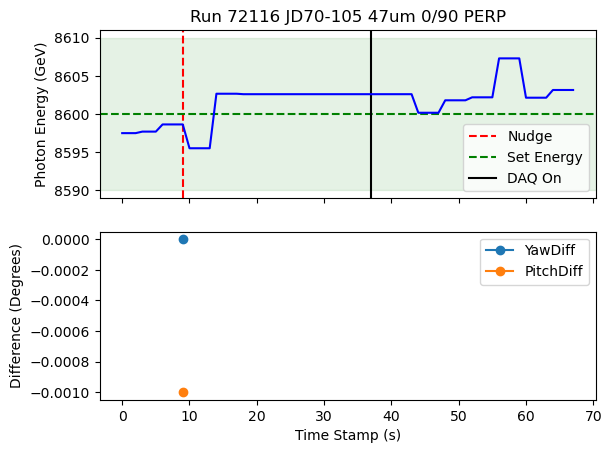

Number of small nudges 1.0
Energy at Nudge: 8598.65
Energy after 10 seconds: 8602.61
plotting for run  72274


<Figure size 640x480 with 0 Axes>

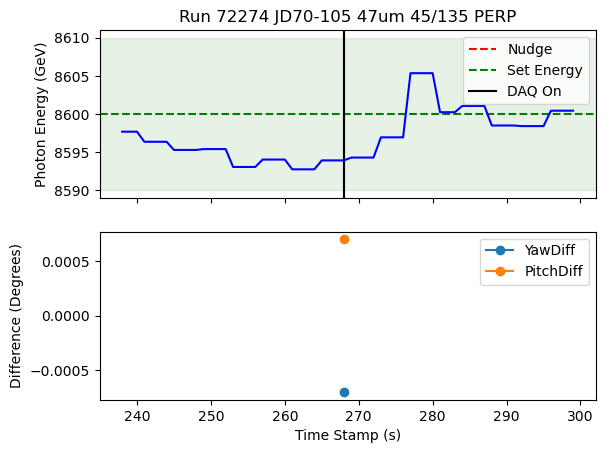

Number of small nudges 1.0
Energy at Nudge: 8593.94
Energy after 10 seconds: 8605.36
plotting for run  72707


<Figure size 640x480 with 0 Axes>

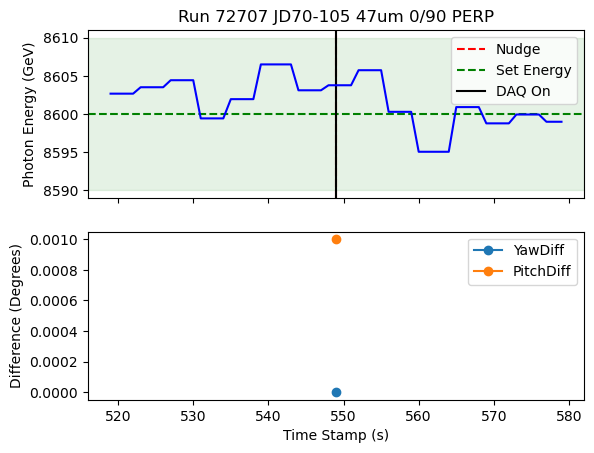

Number of small nudges 1.0
Energy at Nudge: 8603.78
Energy after 10 seconds: 8600.3
plotting for run  72781


<Figure size 640x480 with 0 Axes>

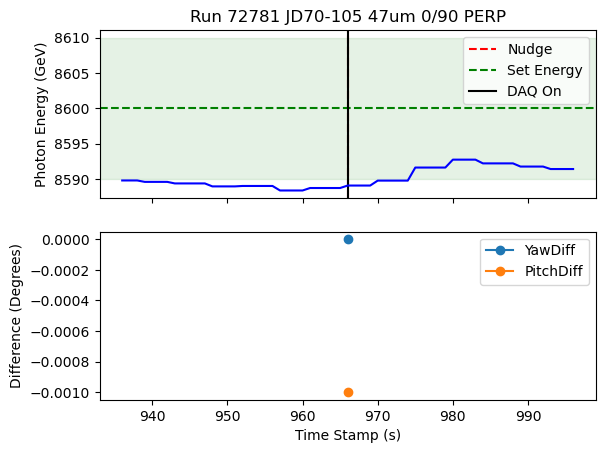

Number of small nudges 1.0
Energy at Nudge: 8589.06
Energy after 10 seconds: 8591.61
plotting for run  73056


<Figure size 640x480 with 0 Axes>

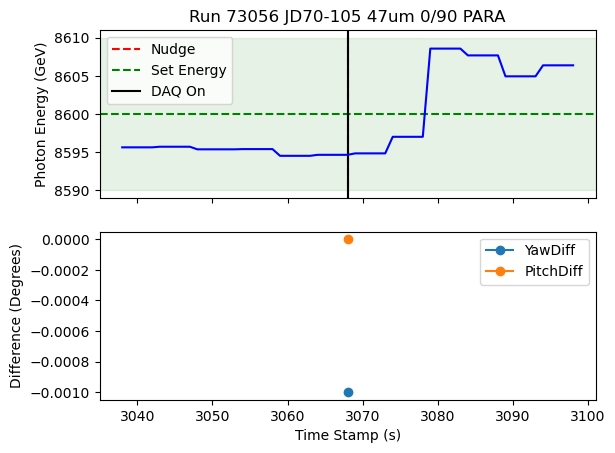

Number of small nudges 1.0
Energy at Nudge: 8594.67
Energy after 10 seconds: 8597.03
plotting for run  73109


<Figure size 640x480 with 0 Axes>

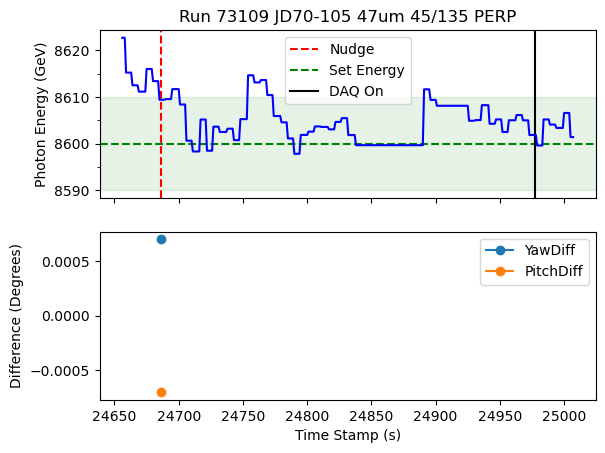

Number of small nudges 1.0
Energy at Nudge: 8609.4
Energy after 10 seconds: 8611.67


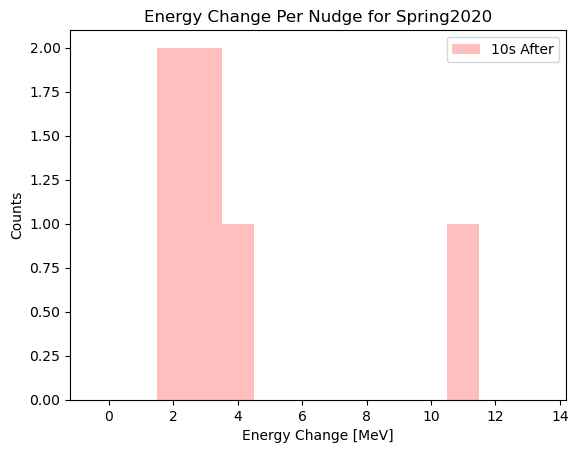

In [15]:
energy_per_nudge(df_2020, nudge_run_list_2020, "Spring2020")

plotting for run  120412


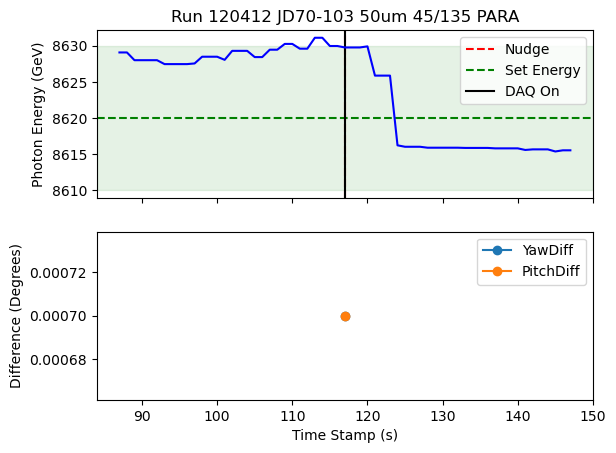

Number of small nudges 1.0
Energy at Nudge: 8629.76
Energy after 10 seconds: 8616.04
plotting for run  121183


<Figure size 640x480 with 0 Axes>

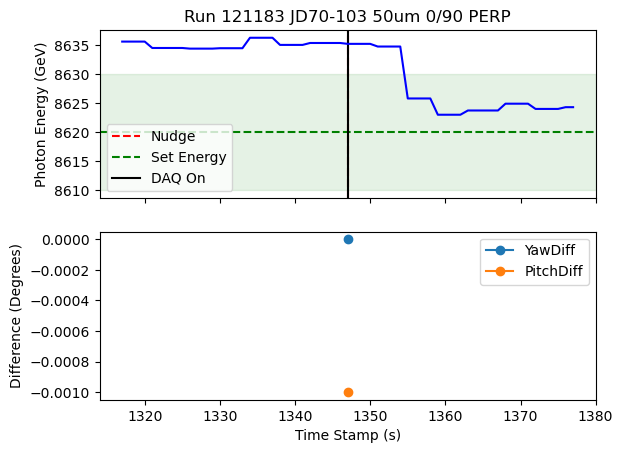

Number of small nudges 1.0
Energy at Nudge: 8635.24
Energy after 10 seconds: 8625.84


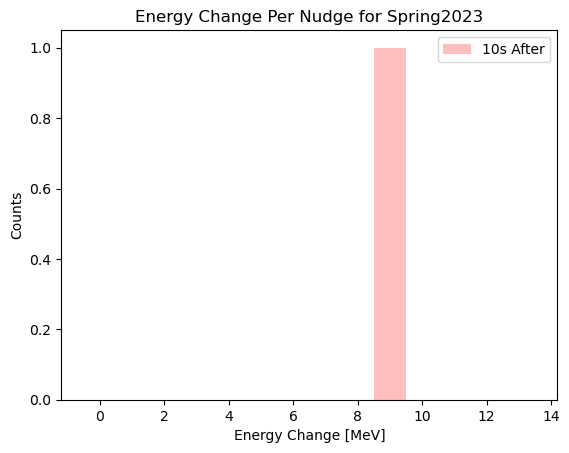

In [16]:
energy_per_nudge(df_2023, nudge_run_list_2023, "Spring2023")

plotting for run  131866


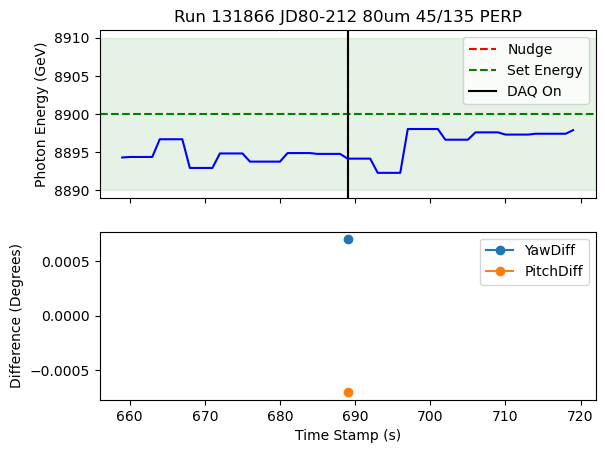

Number of small nudges 1.0
Energy at Nudge: 8894.17
Energy after 10 seconds: 8898.05
plotting for run  131870


<Figure size 640x480 with 0 Axes>

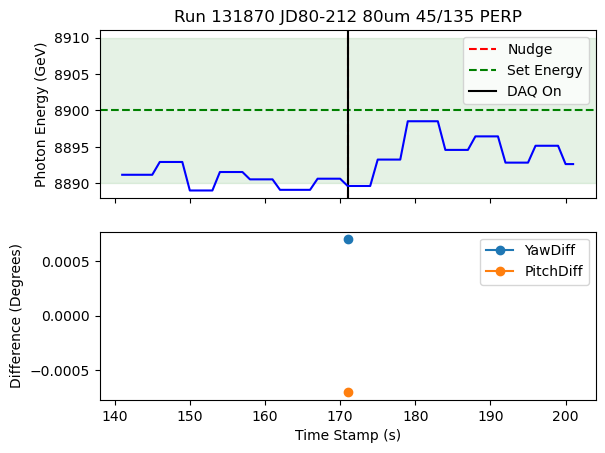

Number of small nudges 1.0
Energy at Nudge: 8889.62
Energy after 10 seconds: 8898.52
plotting for run  131891


<Figure size 640x480 with 0 Axes>

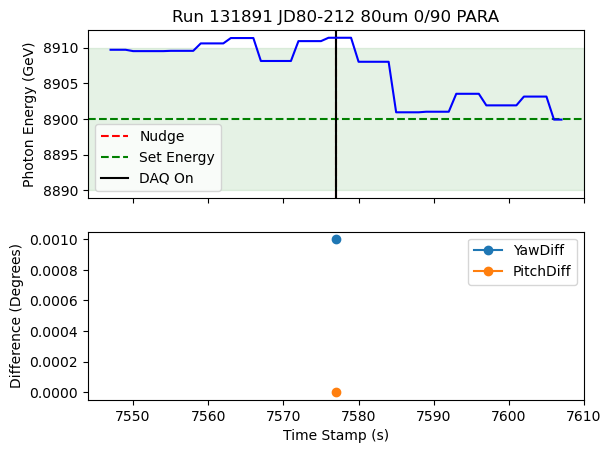

Number of small nudges 1.0
Energy at Nudge: 8911.37
Energy after 10 seconds: 8900.94
plotting for run  131905


<Figure size 640x480 with 0 Axes>

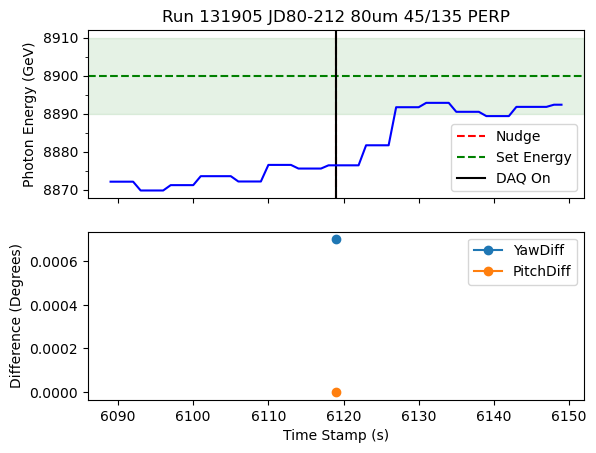

Number of small nudges 0.7
Energy at Nudge: 8876.39
Energy after 10 seconds: 8891.7


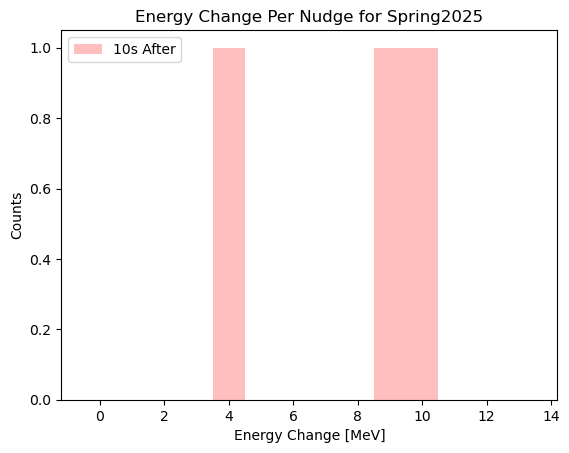

In [17]:
energy_per_nudge(df_2025, nudge_run_list_2025, "Spring2025")